In [1]:
#SARIMAX function can fit all the models in the family
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import warnings
from math import sqrt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


ImportError: ignored

In [ ]:
# define all the functions we will need 

# trend and seasonal differencing
def diff(data, interval=1):
    diff = list()
    for i in range(interval, len(data)):
        value = data[i] - data[i - interval]
        diff.append(value)
    return diff
#trend differencing: interval=1
#seasonal differencing: interval=m


#grid order search based on BIC
#auto-arima order selection in pmdarima
#python -m pip install pmdarima doesn't work for my python 3.9 anymore, so I wrote one

def bic_sarima(data, p_values,d_values,q_values,P_values,Q_values,m_values, D=1): #added m_values
    best_score, best_order, best_seasonal_order = float("inf"), None, None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                    for P in P_values:
                            for Q in Q_values:
                                for m in m_values:
                                    order=(p,d,q)
                                    seasonal_order=(P,D,Q,m)
                                    try:
                                        res = sm.tsa.statespace.SARIMAX(data,order=order,seasonal_order=seasonal_order,enforce_stationarity=False,enforce_invertibility=False).fit()
                                        bic=res.bic
                                        if bic < best_score:
                                            best_score, best_order, best_seasonal_order=bic, order,seasonal_order
                                    except:
                                        continue
    print((best_score, best_order, best_seasonal_order))
    
#model evaluation based on RMSE and one-step cross validation
def rmse_sarima(X, trend_order, seasonal_order, split_size): #added split_size
    train_size = int(len(X) * split_size)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = sm.tsa.statespace.SARIMAX(history, order=trend_order,seasonal_order=seasonal_order)
        res = model.fit()
        yhat = res.predict(start=len(history), end=len(history)) #predict one step
        predictions.append(yhat) #store prediction
        history.append(test[t]) #store observation
        # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

def evaluate_rmse_sarima(data, p_values,d_values,q_values,P_values,Q_values,m, D=1):
    best_score, best_order, best_seasonal_order = float("inf"), None, None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                    for P in P_values:
                            for Q in Q_values:
                                order=(p,d,q)
                                seasonal_order=(P,D,Q,m)
                                try:
                                    rmse=rmse_sarima(data,trend_order=order, seasonal_order=seasonal_order)
                                    if rmse < best_score:
                                        best_score, best_order, best_seasonal_order=rmse, order,seasonal_order
                                except:
                                    continue
    print((best_score, best_order, best_seasonal_order))

In [5]:
pwd


'/content'

In [2]:
#model evaluation based on RMSE and one-step cross validation
def mape_sarima(X, trend_order, seasonal_order, split_size): #added split_size
    train_size = int(len(X) * split_size)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = sm.tsa.statespace.SARIMAX(history, order=trend_order,seasonal_order=seasonal_order)
        res = model.fit()
        yhat = res.predict(start=len(history), end=len(history)) #predict one step
        predictions.append(yhat) #store prediction
        history.append(test[t]) #store observation
        # calculate out of sample error
    mape = mean_absolute_percentage_error(test, predictions)
    return mape

In [4]:
series = pd.read_csv('sbprice.csv', index_col='Date')
x=np.array(series)
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)
ax.plot(series)
plt.show()
plot_acf(series,lags=40) 
plt.show()
plot_pacf(series,lags=40) 
plt.show()

FileNotFoundError: ignored

In [ ]:
dftest = adfuller(series)
dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
print (dfoutput)
#adf test failed (barely), might be acceptable?

#candidate 1: d=1, p=1,q=0, D=1, m=4, P?Q?

Test Statistic   -0.602847
p-value           0.870338
dtype: float64


In [ ]:
def diff(data, interval=1):
    diff = list()
    for i in range(interval, len(data)):
        value = data[i] - data[i - interval]
        diff.append(value)
    return diff

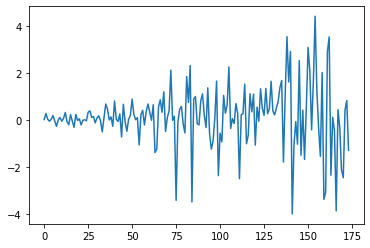

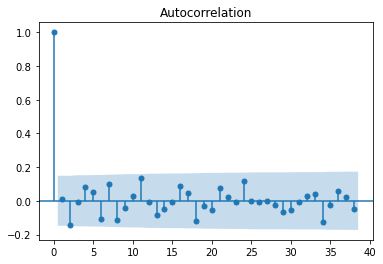

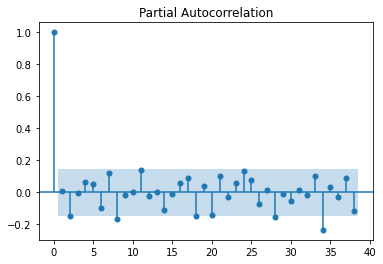

In [ ]:
d1 = diff(series['Adj Close'], 1)
plt.plot(d1)
plot_acf(d1,lags=38) 
plt.show()
plot_pacf(d1,lags=38) 
plt.show()

In [ ]:
dftest = adfuller(d1)
dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
print (dfoutput)
#adf test failed (barely), might be acceptable?

#candidate 1: d=1, p=1,q=0, D=1, m=4, P?Q?

Test Statistic   -1.057714e+01
p-value           7.057906e-19
dtype: float64


In [ ]:
#fixed d, choose p,q
from statsmodels.tsa.stattools import arma_order_select_ic
arma_order_select_ic(d1,max_ar=4, max_ma=4, ic='bic')
######candidate 1: ARIMA(0,1,0)

{'bic':             0           1           2           3           4
 0  586.883714  592.021917  593.855711  598.977311  603.596925
 1  592.027989  587.191113  598.995009  603.897742  608.547048
 2  593.472773  598.631065  625.399192         NaN  638.971370
 3  598.630383  603.758226         NaN  597.700127  614.846141
 4  603.046653  608.072440  613.097127         NaN  615.002171,
 'bic_min_order': (0, 0)}

### Q3
#### a i)

candidate model #1: ARIMA(0,1,0)

In [ ]:
m_values=[0]
d_values=[1,2]
p_values=[0,1,2,3,4]
q_values=[0,1,2,3,4]
Q_values=[0]
P_values=[0]
bic_sarima(series, p_values,d_values,q_values,P_values,Q_values,m_values, D=0)

(580.653260806218, (1, 1, 1), (0, 0, 0, 0))


#### a ii)

candidate model #2: ARIMA(1,1,1)

In [ ]:
m_values=[0]
d_values=[0,2,3,4]
p_values=[0,1,2,3,4,5]
q_values=[0,1,2,3,4,5]
Q_values=[0]
P_values=[0]
bic_sarima(series, p_values,d_values,q_values,P_values,Q_values,m_values, D=0)

(582.5201889357369, (1, 2, 2), (0, 0, 0, 0))


#### a iii)

candidate model #3: ARIMA(1,2,2)

In [ ]:
split_size=0.67
X=series['Adj Close']

rmse1=rmse_sarima(X, (0,1,0), (0,0,0,0), split_size)
rmse2=rmse_sarima(X, (1,1,1), (0,0,0,0), split_size)
rmse3=rmse_sarima(X, (1,2,2), (0,0,0,0), split_size)

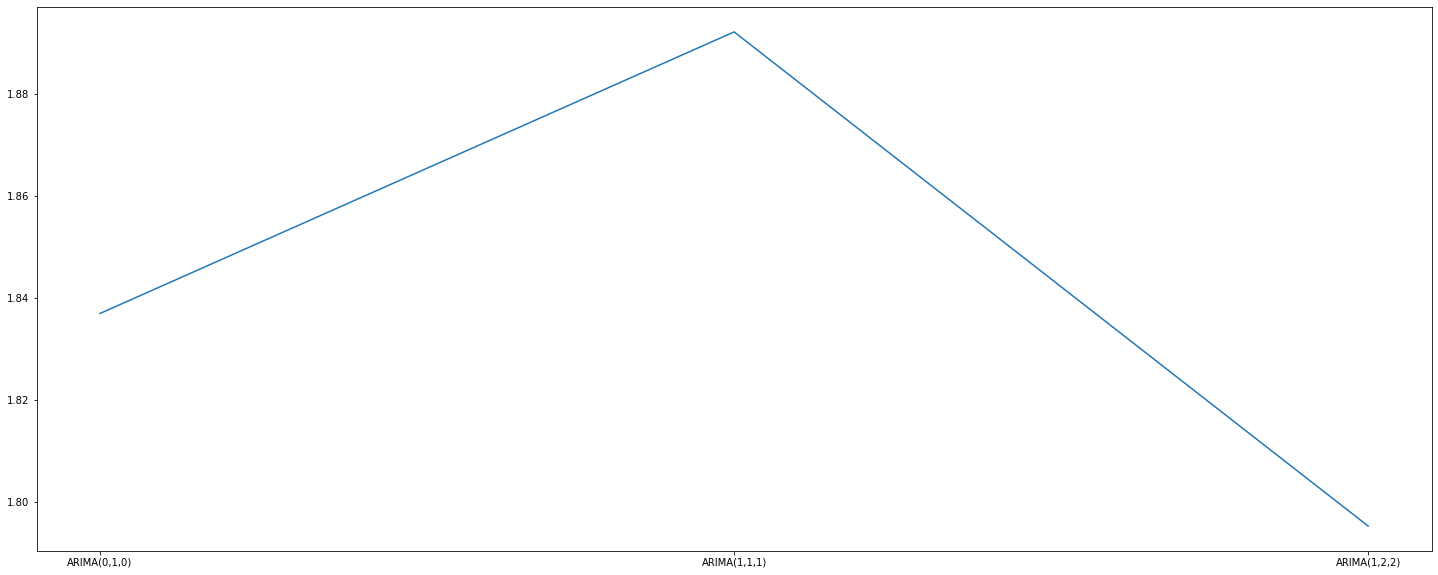

In [ ]:
data = {'ARIMA(0,1,0)': rmse1, 'ARIMA(1,1,1)': rmse2, 'ARIMA(1,2,2)': rmse3}
models = list(data.keys())
rmse = list(data.values())
fig = plt.figure(figsize=(25, 10))
plt.plot(models, rmse)

#### a iv)

RMSE prefers ARIMA(1,2,2)

In [ ]:
split_size=0.67
X=series['Adj Close']

mape1=mape_sarima(X, (0,1,0), (0,0,0,0), split_size)
mape2=mape_sarima(X, (1,1,1), (0,0,0,0), split_size)
mape3=mape_sarima(X, (1,2,2), (0,0,0,0), split_size)

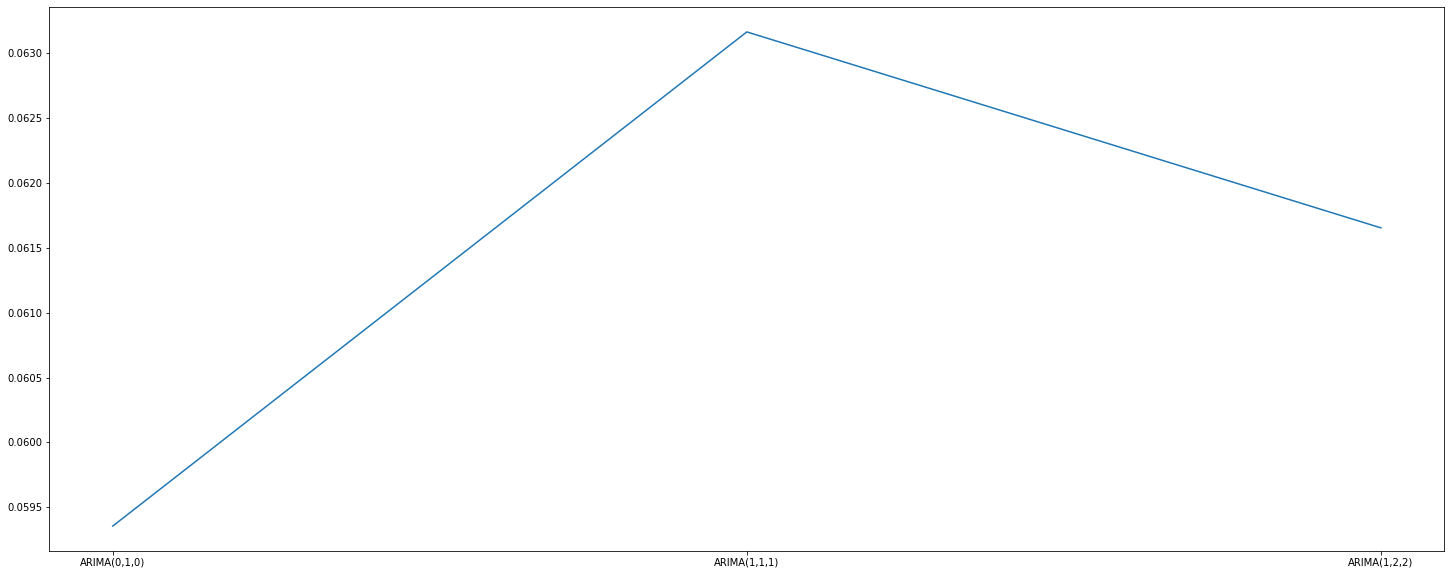

In [ ]:
data = {'ARIMA(0,1,0)': mape1, 'ARIMA(1,1,1)': mape2, 'ARIMA(1,2,2)': mape3}
models = list(data.keys())
mape = list(data.values())
fig = plt.figure(figsize=(25, 10))
plt.plot(models, mape)

MAPE matches to ARIMA(0,1,0)

### Q3

#### b

In [ ]:
series1 = pd.read_csv('../data/sb_out_of_sample.csv', index_col='Date')
# MAPE model ARIMA(0,1,0)
mod1 = sm.tsa.statespace.SARIMAX(series['Adj Close'],order=(0,1,0),seasonal_order=(0,0,0,0))
res1 = mod1.fit()
pred1=res1.predict(start=len(series), end=len(series)+len(series1))
pred1

175    25.09
176    25.09
177    25.09
178    25.09
179    25.09
180    25.09
181    25.09
Name: predicted_mean, dtype: float64

In [ ]:
series1['forecast'] = pred1[175]

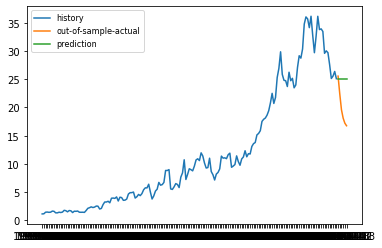

In [ ]:
plt.plot(series['Adj Close'], label='history')
plt.plot(series1['Adj Close'], label='out-of-sample-actual')
plt.plot(series1['forecast'], label='prediction')
# plt.plot(pred1, label='ARIMA(0,1,0) forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### Q4

#### a)

In [ ]:
beer = pd.read_csv('../data/beer.csv', index_col=[0])
beer = beer.set_index('Date')
beer.head()

,Tempurature_Median,Weekend,Beer_Consumption
Date,,,
2015-01-01,27.30,0,25.461
2015-01-02,27.02,0,28.972
2015-01-03,24.82,1,30.814
2015-01-04,23.98,1,29.799
2015-01-05,23.82,0,28.900


In [ ]:
history = beer[:'2015-11-30']
test = beer['2015-12-01':]

#### b)

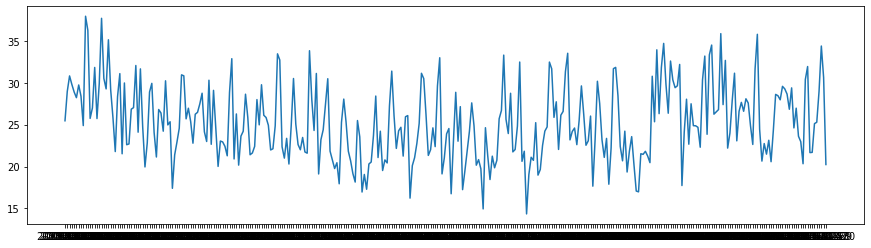

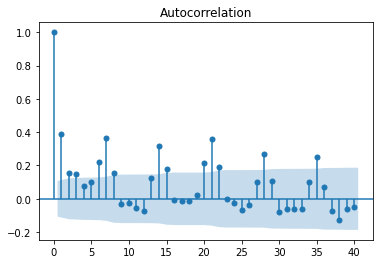

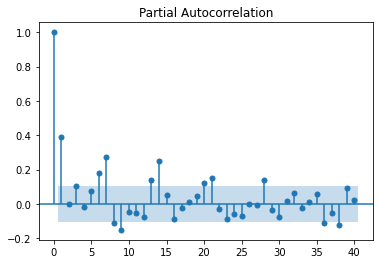

In [ ]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)
ax.plot(history['Beer_Consumption'])
plt.show()
plot_acf(history['Beer_Consumption'],lags=40) 
plt.show()
plot_pacf(history['Beer_Consumption'],lags=40) 
plt.show()

In [ ]:
dftest = adfuller(history['Beer_Consumption'])
dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
print (dfoutput)

Test Statistic   -3.394400
p-value           0.011151
dtype: float64


#### c)

In [ ]:
m_values=[0,7,30]
d_values=[0,1]
p_values=[0,1,2,3]
q_values=[0,1,2,3]
Q_values=[0,1,2,]
P_values=[0,1,2,]
bic_sarima(history['Beer_Consumption'], p_values,d_values,q_values,P_values,Q_values,m_values, D=1)

#### d)

In [ ]:
m_values=[0]
d_values=[0]
p_values=[0]
q_values=[0]
Q_values=[0]
P_values=[0]
bic_sarima(history['Beer_Consumption'], p_values,d_values,q_values,P_values,Q_values,m_values, D=1)

#### e)

In [ ]:
split_size=0.8
X=history['Beer_Consumption']

mape1=mape_sarima(X, (0,1,0), (0,0,0,0), split_size)
mape2=mape_sarima(X, (0,1,0), (0,0,0,0), split_size)
print(mape1, mape2)

#### f)

In [ ]:
mod = sm.tsa.statespace.SARIMAX(history['Beer_Consumption'],order=(0,1,0),seasonal_order=(0,0,0,0))
res = mod1.fit()
pred= res1.predict(start=len(history), end=len(history)+len(test))
pred

In [ ]:
series1['forecast'] = pred1[175]

In [ ]:
plt.plot(history['Beer_Consumption'], label='history')
plt.plot(test['Beer_Consumption'], label='test actual')
plt.plot(test['forecast'], label='prediction')
# plt.plot(pred1, label='ARIMA(0,1,0) forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()